# Simulations modèle ICSV

In [1]:
import vocal_tract_constrained_cpp as vc
from body_vocal_tract import *
from terminal_impedance import *

import pyphs as phs
import sympy as sy
import numpy as np
import os
import datetime
import pickle
import sympy as sy
import matplotlib.pyplot as plt
from scipy.io.wavfile import write as wavWrite
import h5py
sy.init_printing()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

PPTY_PHY_PARAMS = {"positive": True, "real" : True }                            
PPTY_STATE_VAR  = {"real" : True }

import pdb

In [2]:
import time
import datetime
class Timer(object):
    """ 
    Allows one to time a particular set of actions.
    
    Example:
    ```(Python)
        with Timer('foo_stuff'):
           # do some foo
           # do some stuff
    ```
    
    Credit: Eli Bendersky
    https://stackoverflow.com/questions/5849800/what-is-the-python-equivalent-of-matlabs-tic-and-toc-functions
    """
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()
        currentDT = datetime.datetime.now()
        print('Start: ' + str(currentDT))

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name,)
        print('Elapsed: {:4.2f} sec'.format(time.time() - self.tstart))

In [3]:
phs.__version__
IMPULSE_RESPONSE = True

## Instanciation de l'objet `core`
On considère que la largeur $L$ est égale à la hauteur au repos $h_0$ pour un tronçon donné.

Pour la voyelle A, on prend $A_1 = \frac{1}{10} A_2$ avec $A_i$ l'aire de la section du tronçon $i=1,2$.

In [4]:
#from importlib import reload  
#reload(vc)

N_tube       = 7
label        = 'vocal_tract'
forme_model  = 'quad_comp_shift'
total_length = 0.175

h = 0.02 
L = h


h_ray = 0.08
Sray = (h_ray)**2

VT_subs = {
        'P_0'       : 101.325e03,
        'rho_0'     : 1.225,
        'gamma'     : 1.4,
        'Z_ray'     : 128/(9*Sray),
        }

# Calcul des V0
for i in range(N_tube): # V = 2 * ell * L * h
    ind = str(i+1)
    VT_subs["ell_" + ind] = total_length/(2*N_tube)
    VT_subs["L_" + ind]   = L
    Sw                    = 2*VT_subs['ell_' + ind]*L
    VT_subs["V_0_" + ind] = Sw*h

# Assemblage des dictionnaires
VT_subs_tot = dict(VT_subs)

core = vc.VocalTractLumpedParameter(
                                    N     = N_tube,
                                    label = label,
                                    **VT_subs_tot,
                                    )

assert not core.freesymbols(), 'Il manque des valeurs/échelles'

In [5]:
len(core.x)

In [6]:
# ajout de ressort dans la paroi
body = []
    
for i in range(N_tube):
    body.append(DissipativeSingleSpringBody(n=i+1))
    core = core +  body[i]
    core.add_connector((2, core.y.index(body[i].y[0])), alpha=-1)
    

# ajout d'une impédance de rayonnement
composant_impedance = RadiationImpedance()
core = core + composant_impedance
core.add_connector((1, core.y.index(composant_impedance.y[0])), alpha=1)


core.connect()

In [7]:
## Update subs
body_subs = {}
for i in range(1,N_tube+1):    
    body_subs['k_' + str(i)] = 845
    body_subs['r_' + str(i)] = 0.8

core.subs.update(                                                       
    {core.symbols(k,**PPTY_PHY_PARAMS): v for k, v in body_subs.items()}   
)

## Configuration de la simulation
Initialisation des états/observateurs puis paramètres de la simulation

In [8]:
inits = {'x' : [0.0 for i in range(len(core.x))]}

Calcule des initialisations des observateurs

In [9]:
expr_obs = []
lab_obs = []
subs = {}

# On récupère les observateurs et leurs expressions
for key, val in core.observers.items():
    subs[key] = val.subs(core.subs)
    lab_obs.append(key)
    expr_obs.append(val.subs(subs).subs(core.subs))
    
# On créé les fonctions numpy
f_obs = []
for expr in expr_obs:
    f_obs.append(sy.lambdify(core.x, expr))
    
# On évalue les fonctions
init_obs = []
for func in f_obs:
    init_obs.append(func(*inits['x']))
    
# Formattage numpy
init_obs = np.array(init_obs).T


In [10]:
inits['o'] = init_obs

In [11]:
config = {'fs'   : 1e6, # sample rate (Hz)
          'path' : os.path.join(os.getcwd(), '03_data'), # folder for output results/build
          'lang' : 'c++',
          'cmake': r'cmake',
          'grad' : 'discret',
          'maxit': 20,
          'pbar' : False,
          'split': False,
          'timer': True,
          'epsdg': np.power(np.finfo(np.float64).eps, 0.5),
          'eps'  : np.finfo(np.float64).eps,
         }
print(np.finfo(np.float64).eps)


with Timer('Building method'):
    simu = core.to_simulation(
                              config, 
                              erase = True,
                              inits = inits
                             )

2.220446049250313e-16
Start: 2020-05-15 11:17:57.827977
Build method vocal_tract...
    Init Method...
    Build numerical structure...
    Init update actions...
    Init arguments...
        Build x
        Build dx
        Build w
        Build u
        Build p
        Build vnl
        Build o
    Init functions...
        Build z
        Build ud_o
        Build dxH
        Build jacGnlnl
        Build Gnl
        Build y
Prepare method vocal_tract for C++ generation...
    Init value for x
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Init value for dx
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    Init value for ud_x
    Init value for o
[0.0784000000000000, 0.0784000000000000, 0.0784000000000000, 0.0784000000000000, 0.0784000000000000, 0.0784000000000000, 0.0784000000000000, 

In [12]:
tmax  = 0.25
Nit   = int(tmax*config['fs'])
t_vec = np.linspace(0, tmax, Nit)

## Modifying core cpp and h files

In [13]:
import modify_core_solver as modifs
folder_path_in = os.path.join(config['path'],label, 'src')
modifs.insert_solver(folder_path_in, N_tube)

on initialise les observateurs à leur valeur au repos

## Signaux d'entrée

In [14]:
t_imp = 0.01
ind_start = int(t_imp*config['fs'])
if IMPULSE_RESPONSE:
    u = np.zeros((Nit, len(core.u)))
    u[ind_start,0] = 1

## Simulation

In [15]:
print('Build de la simulation à {0}'.format(datetime.datetime.now()))
simu.init(
        u     = u,
        nt    = Nit,
        #inits = inits
        )
print('Simulation démarée à {0}'.format(datetime.datetime.now()))
with Timer('Simulation'):
    simu.process()
print('Simulation finie à {0}'.format(datetime.datetime.now()))

Build de la simulation à 2020-05-15 11:22:53.085620
Write u to hdf5 file...
Write u to hdf5 file: Done.
Simulation démarée à 2020-05-15 11:22:59.677703
Start: 2020-05-15 11:22:59.678075
Simulation: Process...
-- The CXX compiler identification is GNU 9.3.0

-- Check for working CXX compiler: /usr/bin/c++

-- Check for working CXX compiler: /usr/bin/c++ - works

-- Detecting CXX compiler ABI info

-- Detecting CXX compiler ABI info - done

-- Detecting CXX compile features

-- Detecting CXX compile features - done

-- HDF5: Using hdf5 compiler wrapper to determine CXX configuration

-- Found HDF5: /usr/lib/libhdf5_cpp.so;/usr/lib/libhdf5.so;/usr/lib/libsz.so;/usr/lib/libz.so;/usr/lib/libdl.so;/usr/lib/libm.so (found version "1.12.0") found components: HL CXX 

-- Configuring done

-- Generating done

-- Build files have been written to: /home/victorw/ownCloud/IRCAM/03_DOCS/30_code_cpp_vocal_tract/vocalTractCpp/02_python/03_data/vocal_tract/build

Scanning dependencies of target vocal_tr

## Données
On fait l'évaluation des observateurs nous même pour gagner du temps

In [16]:
# Date, heure etc...
timedate_now = datetime.datetime.now()
month  = timedate_now.month
day    = timedate_now.day
hour   = timedate_now.hour
minute = timedate_now.minute
date_now = [str(month).zfill(2), str(day).zfill(2), str(hour).zfill(2), str(minute).zfill(2)]

filename = '03_data/simu.{0}_{1}.{2}_{3}.h5'.format(*date_now)
fid      = h5py.File(filename, 'x')
dt       = h5py.string_dtype()

# Creating groups
data_simu     = fid.create_group('data_simu')
metadata      = fid.create_group('metadata')
model         = fid.create_group('model')
fid.flush()

# Saving signals
data = np.array( list(simu.data.u())     , dtype=np.float64).squeeze()
data_simu.create_dataset("u", data=data)

data = np.array( list(simu.data.y())     , dtype=np.float64).squeeze()
data_simu.create_dataset("y", data=data)

data = np.array( list(simu.data.x())     , dtype=np.float64).squeeze()
data_simu.create_dataset("x", data=data)

#data = np.array( list(data_obs)     , dtype=np.float64).squeeze()
#data_simu.create_dataset("o", data=data)

data = np.array( list(simu.data.dx())    , dtype=np.float64).squeeze()
data_simu.create_dataset("dx", data=data)

data = np.array( list(simu.data.dxH())   , dtype=np.float64).squeeze()
data_simu.create_dataset("dxH", data=data)

data = np.array( list(simu.data.dtx())   , dtype=np.float64).squeeze()
data_simu.create_dataset("dtx", data=data)

data = np.array( list(simu.data.w())   , dtype=np.float64).squeeze()
data_simu.create_dataset("w", data=data)
data = np.array( list(simu.data.z())   , dtype=np.float64).squeeze()
data_simu.create_dataset("z", data=data)

# time vector
data = t_vec
data_simu.create_dataset("t", data=data)

data

data = inits['x']
data_simu.create_dataset("init_X", data=data)


#data = inits['o']
#data_simu.create_dataset("init_o", data=data)


#### données sur le modèle
model.create_dataset(name="N_tube", shape=(1,),data=N_tube)
model.create_dataset(name="forme model", data=str(forme_model))

subs = VT_subs
place = model.create_group("VT_subs")

for key, val in subs.items():
    place.create_dataset(name=key, data=val)

subs = body_subs
place = model.create_group("body_subs")
for key, val in subs.items():
    place.create_dataset(name=key, data=val)
    
# labels
str_x_label = []
str_u_label = []
str_y_label = []
str_o_label = []
str_w_label = []

Nx = len(core.x)
Nw = len(core.w)
Nu = len(core.u)
model.create_dataset("Nw", (1,), data=Nw)
model.create_dataset("Nx", (1,), data=Nx)
model.create_dataset("Nu", (1,), data=Nu)

for label in core.x:
    str_x_label.append(str(label).encode('ascii'))
for label in core.w:
    str_w_label.append(str(label))
for label in core.u:
    str_u_label.append(str(label))
for label in core.y:
    str_y_label.append(str(label))
for label in core.o():
    str_o_label.append(str(label))

data = np.array(str_x_label, dtype='S')
model.create_dataset("x_label", shape=data.shape, data=data, dtype=dt)

data = np.array(str_o_label, dtype='S')
model.create_dataset("o_label", shape=data.shape, data=data, dtype=dt)

data = np.array(str_w_label, dtype='S')
model.create_dataset("w_label", shape=data.shape, data=data, dtype=dt)

data = np.array(str_y_label, dtype='S')
model.create_dataset("y_label", shape=data.shape, data=data, dtype=dt)

data = np.array(str_u_label, dtype='S')
model.create_dataset("u_label", shape=data.shape, data=data, dtype=dt)


### Config de la simu
subs = config
metadata.create_dataset("config",(1,),data=str(subs), dtype=dt)

data = phs.__version__
metadata.create_dataset("pyphs_version",(1,),data=str(data), dtype=dt)

data = Nit
metadata.create_dataset("Nit", data=data)



data = date_now
for i, el in enumerate(data):
    data[i] = int(el)
metadata.create_dataset("date_now", data=data)

del data

fid.flush()
fid.close()
%store filename

Stored 'filename' (str)


03_data/simu.05_15.11_27.h5
5 15 11 27
L_1 = 0.020000
L_2 = 0.020000
L_3 = 0.020000
L_4 = 0.020000
L_5 = 0.020000
L_6 = 0.020000
L_7 = 0.020000
P_0 = 101325.000000
V_0_1 = 0.000010
V_0_2 = 0.000010
V_0_3 = 0.000010
V_0_4 = 0.000010
V_0_5 = 0.000010
V_0_6 = 0.000010
V_0_7 = 0.000010
Z_ray = 2222.222222
ell_1 = 0.012500
ell_2 = 0.012500
ell_3 = 0.012500
ell_4 = 0.012500
ell_5 = 0.012500
ell_6 = 0.012500
ell_7 = 0.012500
gamma = 1.400000
rho_0 = 1.225000


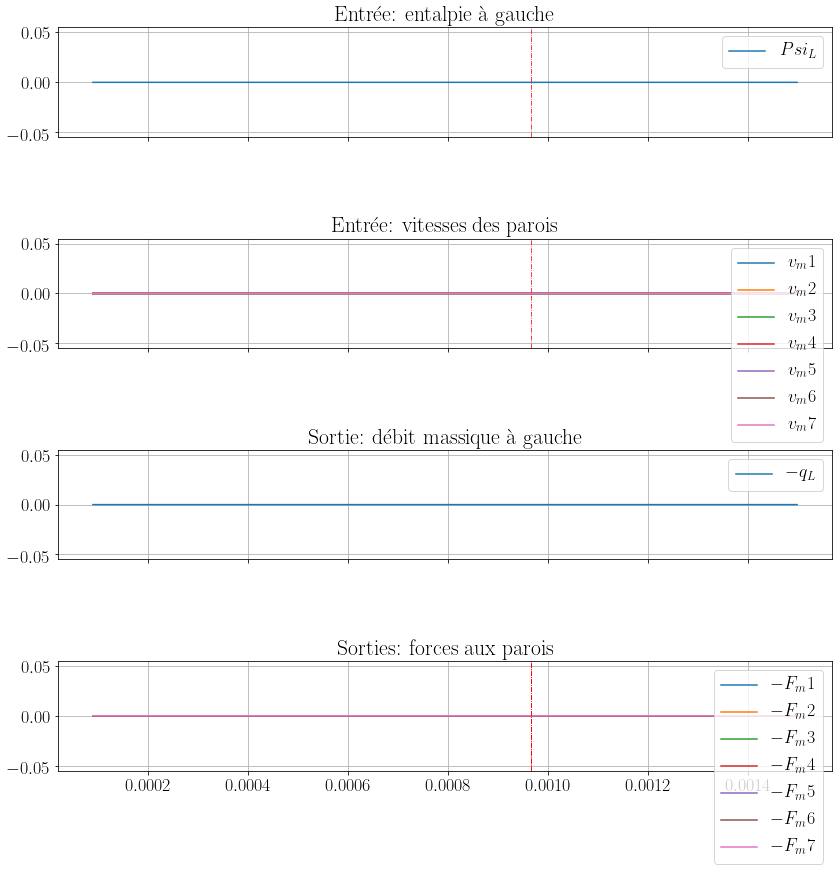

/home/victorw/.virtualenvs/pyphs/lib/python3.8/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/victorw/.virtualenvs/pyphs/lib/python3.8/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


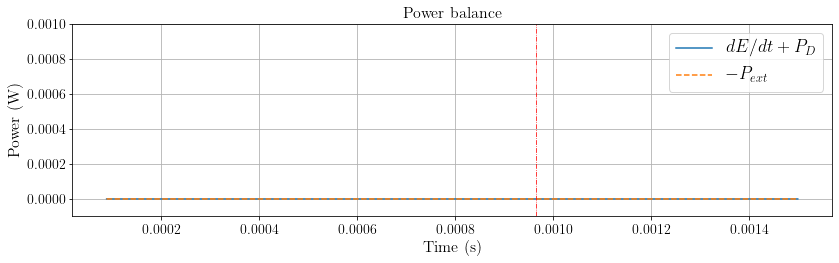

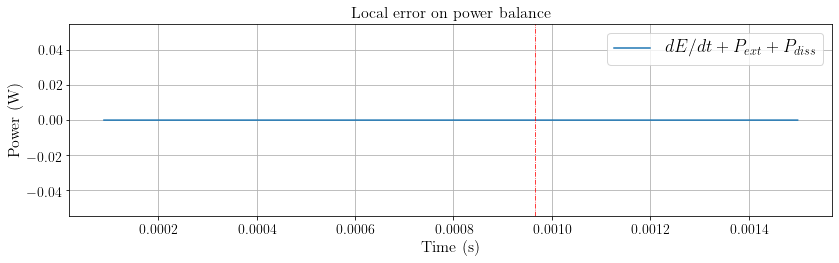

['-q_L' '-F_m1' '-F_m2' '-F_m3' '-F_m4' '-F_m5' '-F_m6' '-F_m7']
['v_k1' 'v_k2' 'v_k3' 'v_k4' 'v_k5' 'v_k6' 'v_k7' 'q']
0 : nu_L1
1 : nu_12
2 : nu_23
3 : nu_34
4 : nu_45
5 : nu_56
6 : nu_67
7 : nu_R7
8 : Pi_y1
9 : Pi_y2
10 : Pi_y3
11 : Pi_y4
12 : Pi_y5
13 : Pi_y6
14 : Pi_y7
15 : V_1
16 : V_2
17 : V_3
18 : V_4
19 : V_5
20 : V_6
21 : V_7
22 : rho_1
23 : rho_2
24 : rho_3
25 : rho_4
26 : rho_5
27 : rho_6
28 : rho_7
29 : x_k1
30 : x_k2
31 : x_k3
32 : x_k4
33 : x_k5
34 : x_k6
35 : x_k7
0 : v_k1
1 : v_k2
2 : v_k3
3 : v_k4
4 : v_k5
5 : v_k6
6 : v_k7
7 : q


<IPython.core.display.Javascript object>


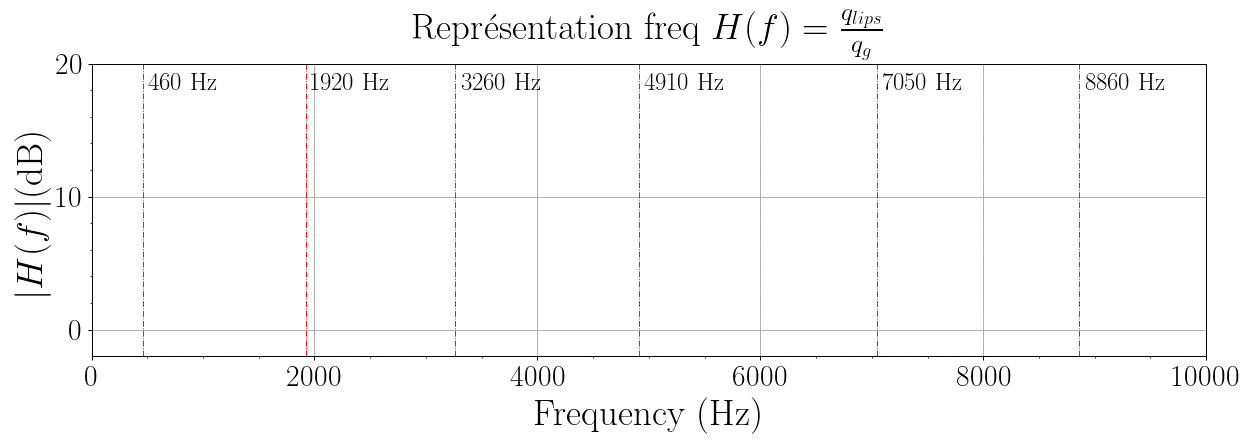

x_k2


<IPython.core.display.Javascript object>


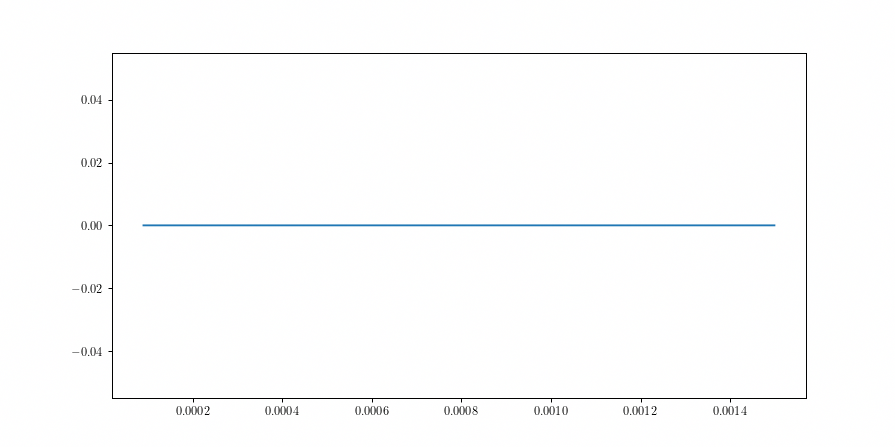

In [17]:
%run ./01_GRAPHS_tube_uniforme.ipynb